In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn import metrics
from sklearn.utils.testing import ignore_warnings
import pickle
import joblib
from datetime import datetime
from scipy.stats import spearmanr, kendalltau 
import multiprocessing as mp
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from scipy.sparse import coo_matrix
from functools import partial

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Сначала загружаем данные и делаем базовый препроцессинг.

In [3]:
players = joblib.load('chgk/players.pkl')
results = joblib.load('chgk/results.pkl')
tournaments = joblib.load('chgk/tournaments.pkl')

tournaments_data = pd.DataFrame(list(tournaments.values())).loc[:, ['id', 'dateStart', 'dateEnd', 'type', 'questionQty']]
tournaments_data['type'] = tournaments_data['type'].apply(lambda x: x['id'])
tournaments_data['dateStart'] = pd.to_datetime(tournaments_data['dateStart'], utc=True).dt.tz_localize(None)
tournaments_data['dateEnd'] = pd.to_datetime(tournaments_data['dateEnd'], utc=True).dt.tz_localize(None)
tournaments_data['length'] = ((tournaments_data.dateEnd - tournaments_data.dateStart) / 
                              np.timedelta64(1,'h')).astype(int)
tournaments_data = tournaments_data.loc[tournaments_data.dateStart >= pd.to_datetime('2018-09-01'), 
                                        ['id', 'dateStart', 'length', 'type', 'questionQty']]

results_data = []
for tournament_id in tournaments_data.id:
    teams_count = len(results[tournament_id])
    for team_id, team_result in enumerate(results[tournament_id]):
        if 'mask' not in team_result or team_result['mask'] is None:
            continue
        mask, position = team_result['mask'], team_result['position']
        relative_position = 1 - position / teams_count
        for team_member in team_result['teamMembers']:
            player_id = team_member['player']['id']
            results_data.append((tournament_id, team_id, player_id, mask, teams_count, position, relative_position))
results_data = pd.DataFrame(results_data, columns=['tournament_id', 'team_id', 'player_id', 'mask', 'teams_count', 'position', 'relative_position'])

tournaments_data = tournaments_data.loc[tournaments_data.id.isin(results_data.tournament_id)]

df = pd.merge(tournaments_data, results_data, left_on='id', right_on='tournament_id').sort_values(['dateStart']).reset_index(drop=True)
df = df[df.tournament_id.isin(df.tournament_id.unique()[df.groupby(['tournament_id']).team_id.nunique() > 1])]

In [64]:
def enrich_player_statistics(df, player_id):
    """Добавляем различную статистику по играм игрока player_id (для baseline модели не используется):
    - tournaments_played_last_N_month: количество турниров, которые игрок сыграл за последние N месяцев
    - avg_position_last_N_month: какое в среднем место занимал игрок за последние N месяцев
    - avg_position_last_N_tournaments: какое в среднем место занимал игрок за последние N турниров
    - days_since_last_tournament: сколько прошло дней с последнего турнира
    - top_1_streak: сколько турниров подряд игрок уже выиграл
    - top_3_streak: сколько турниров подряд игрок занимает top 3 место 
    """
    
    player_data = df.loc[df.player_id == player_id].sort_values(['dateStart'])
    player_data_indexed = player_data.set_index('dateStart')
    
    player_data['tournaments_played_last_1_month'] = player_data_indexed.rolling('30D')['id'].count().values
    player_data['tournaments_played_last_2_month'] = player_data_indexed.rolling('60D')['id'].count().values
    player_data['tournaments_played_last_3_month'] = player_data_indexed.rolling('90D')['id'].count().values
        
    player_data['avg_position_last_1_month'] = player_data_indexed.rolling('30D').relative_position.mean().values
    player_data['avg_position_last_2_month'] = player_data_indexed.rolling('60D').relative_position.mean().values
    player_data['avg_position_last_3_month'] = player_data_indexed.rolling('90D').relative_position.mean().values
    
    player_data['avg_position_last_1_tournaments'] = player_data.rolling(1).relative_position.mean().values
    player_data['avg_position_last_2_tournaments'] = player_data.rolling(2).relative_position.mean().values
    player_data['avg_position_last_3_tournaments'] = player_data.rolling(3).relative_position.mean().values
    
    player_data['days_since_last_tournament'] = (player_data.dateStart - player_data.dateStart.shift()).dt.days
    
    top_1_streak = (player_data.position == 1).astype(int)
    top_1_streak = top_1_streak.cumsum() - top_1_streak.cumsum().where(top_1_streak == 0).ffill().fillna(0).astype(int)
    
    top_3_streak = (player_data.position <= 3).astype(int)
    top_3_streak = top_3_streak.cumsum() - top_3_streak.cumsum().where(top_3_streak == 0).ffill().fillna(0).astype(int)
    
    player_data['top_1_streak'] = top_1_streak
    player_data['top_3_streak'] = top_3_streak
    
    return player_data.fillna(player_data.mean())

def compile_whole_sample(df):
    results = []
    for i, id_ in enumerate(df.player_id.unique()):
        results.append(enrich_player_statistics(df, id_))
    return pd.concat(results)

    
def expand_questions_row(df, row_n):
    """Разворачиваем повопросную маску так, чтобы для каждой пары (игрок - вопрос - ответ) была одна строчка в данных.
    Также нумеруем вопросы. 
    """
    
    row = df.iloc[row_n]
    rounds = len(row['questionQty'])
    questions = []
    n = 0
    for i, num in row['questionQty'].items():
        for j in range(num):
            n += 1
            score = 0
            if n <= len(row['mask']):
                if row['mask'][n - 1] == '1':
                    score = 1
            questions.append((rounds, i, j, n, score))
    qdf = pd.DataFrame(questions, columns=['rounds', 'round', 'question_round_number', 'question_global_number', 'score'])
    return df.iloc[[row_n] * n].reset_index(drop=True).join(qdf)

def enrich_sample_with_rows(sample):
    return pd.concat([expand_questions_row(sample, i) for i in range(sample.shape[0])])


def get_x(df):
    """Констурируем спарсную матрицу для обучения - сначала идет OHE по игрокам потом OHE по вопросам 
    """
    
    N = df.shape[0]
    M = df.question_num.max() + 1
    
    data = np.concatenate([np.ones(N), -np.ones(N)])
    df_ = df.reset_index(drop=True).reset_index()
    i = np.concatenate([df_['index'].values, df_['index'].values])
    j = np.concatenate([df_['player_num'].values, df_['question_num'].values])
    return coo_matrix((data, (i, j)), shape=(N, M))

def get_x_for_weighted(df):
    """Спарсная матрица для обучения, добавляем дополнительный дублирующий блок с y_i == 1 для обучения с весами на 0 и 1
    """
                          
    N_good = df[df.score == 1].shape[0]
    N = df.shape[0]
    M = df.question_num.max() + 1
    
    data = np.concatenate([np.ones(N), -np.ones(N), np.ones(N_good), -np.ones(N_good)])
#     data = np.ones((N_good + N) * 2)
    df_ = df.reset_index(drop=True).reset_index()
    df_good_ = df[df.score == 1].reset_index(drop=True).reset_index()
    
    i = np.concatenate([df_['index'].values, df_['index'].values, 
                        N + df_good_['index'].values, N + df_good_['index'].values])
    
    j = np.concatenate([df_['player_num'].values, df_['question_num'].values,
                        df_good_['player_num'].values, df_good_['question_num'].values])
    
    return coo_matrix((data, (i, j)), shape=(N + N_good, M))

def team_rating(players):
    """Считаем рейтинг команды - как вероятность того, что хотя бы один игрок ответит на вопрос.
    """
                          
    return 1 - np.prod(1 - players)

def transform_prob(x, q):
    return team_rating(sigmoid(x - q))

def transform_proba_m(p, m):
    """Имея априорные вероятности каждого игрока ответить на вопрос, трансформируем этот вектор в апосториорные вероятности,
    если известно что из них на вопрос ответило ровно m игроков. Для этого используем Poisson Binomial Distribution
    """
    
    pbs = [PoiBin(np.delete(p, i)) for i in range(len(p))]
    pbs_m = np.array([x.pmf(m) for x in pbs])
    pbs_m_1 = np.array([x.pmf(m - 1) for x in pbs])
    return 1 / (1 + (1 - p) * pbs_m / pbs_m_1 / p)

def empirical_distribution(data, n):    
    """Строим эмпирическое распределение по данным, использую для построение распределения сложности вопросов, чтобы далее 
    оценить вероятность того, что игрок ответит на вопрос. см team_rating_
    """                      
                          
    space = np.linspace(min(data), max(data), n + 1)
    distrib = [data[(data >= space[i]) & (data < space[i + 1])] for i in range(n)]
    return [(a.mean(), len(a) / len(data)) for a in distrib if not np.isnan(a.mean()) and len(a) / len(data) > 0]
                          
def team_rating_(xx, question_hardness_distrib):
    """Берем интеграл от вероятности команды ответить на вопрос по распределению сложности вопросов.
    """                      
                          
    y = xx.apply(lambda x: sum(np.array([transform_prob(x, q) * p for q, p in question_hardness_distrib])))
    y = y.reset_index()
    y.columns = ['tournament_id', 'team_id', 'team_rating']
    return y

def tourney_rating_(xx, player_weights_distrib):
    """Берем интеграл от вероятности команды ответить на вопрос по распределению силы игроков.
    """                      
                          
    y = xx.apply(lambda q: sum(np.array([transform_prob(w, q) * p for w, p in player_weights_distrib])))
    y = y.reset_index()
    y.columns = ['tournament_id', 'tourney_rating']
    return y

def compute_model_scores(model, test_data, name):
    """Считаем основные метрики модели. Для этого сортируем команды в соответствие описанной процедуры вычисления вероятности
    команды ответить на вопрос.
    """    
                          
    question_hardness_distrib = empirical_distribution(model.coef_[0][n_players:], 20)
    xdf = pd.merge(train_data[['player_num', 'player_id']],
                   pd.DataFrame({'player_num': range(n_players), 'player_rating': model.coef_[0][:n_players]}))
    xdf = xdf.drop_duplicates()
    
    test_df = pd.merge(test_data, xdf[['player_id', 'player_rating']].drop_duplicates(), how='left')
    test_df = test_df.fillna(test_df.player_rating.mean())

    x_ = test_df.groupby(['tournament_id']).team_id.unique().apply(lambda x: sorted(list(x)))
    
    teams = test_df.groupby(['tournament_id', 'team_id']).apply(lambda x: np.array(x.groupby(['player_id']).player_rating.min()))
    
    pool = mp.Pool(36)
    y_ = pd.concat(pool.map(partial(team_rating_, question_hardness_distrib=question_hardness_distrib), np.array_split(teams, 36)))
    pool.close()
    
    y_ = y_.groupby(['tournament_id']).apply(lambda x: list(x.sort_values(['team_rating'], ascending=False).team_id))
    
    scores = pd.DataFrame({'x':x_, 'y':y_}).apply(lambda r: np.array([spearmanr(r.x, r.y)[0], kendalltau(r.x, r.y)[0]]), axis=1).mean()
    print(f'{name}: spearmanr: {scores.x}, kendalltau: {scores.y}')
    return (scores.x, scores.y)

def construct_scores(question_answered_index, player_prob_answer, n):
    """По сути это E шаг EM алгоритма. Новые скоры считаем так: берем m = E[количество вопросов на которые ответит команда]
    Далее пересчитываем y_i = P( y_i = 1 | ответило m игроков из команды )
    Предположим что ответ на вопрос это i.i.d., поэтому можно сказать что 
    E[количество вопросов на которые ответит команда] = SUM(P( y_i = 1)), в качестве этой вероятности используем предсказания модели.
    При этом мы знаем, что хотя бы один игрок из команды ответил на вопрос, поэтому min(m) = 1
    """                      
                          
    y = np.zeros(n)
    
    for i in range(question_answered_index.shape[0]):
        prob = player_prob_answer[question_answered_index.iloc[i]]

        m = np.int(max(np.round(sum(prob)), 1)) 
        
        if m == len(prob):
            y[question_answered_index.iloc[i]] = 0.99
        else:
            y[question_answered_index.iloc[i]] = transform_proba_m(prob, m)

    return y

def compute_tournaments_hardness(train_data, model, player_weights_distrib):
    dq = pd.DataFrame({'question_num': range(n_players, n_players + n_questions), 'question_hardness': model.coef_[0][n_players:]})
    dq = pd.merge(train_data, dq)
    tourneys = dq.groupby(['tournament_id']).apply(lambda x: np.array(x.groupby(['question_num']).question_hardness.min()))
    return tourney_rating_(tourneys, player_weights_distrib).sort_values(['tourney_rating']).reset_index(drop=True)

Делаем еще различный препроцессинг в итоге получаем два Датасета - train_data и test_data со всей нужной информацией. А также подготовленные матрицы X для baseline модели и X_weighted для EM алгоритма. 

In [14]:
# sample = compile_whole_sample(df)
pool = mp.Pool(36)
sample_by_rows = pd.concat(pool.map(enrich_sample_with_rows, np.array_split(df, 36)))
pool.close()
train_data = sample_by_rows.loc[sample_by_rows.dateStart.dt.year == 2019]
test_data = sample_by_rows.loc[sample_by_rows.dateStart.dt.year == 2020]

train_data['row_id'] = range(train_data.shape[0])
train_data['player_num'] = train_data.groupby(['player_id']).ngroup()
train_data['question_num'] = train_data.groupby(['tournament_id', 'question_global_number']).ngroup() + train_data.player_num.max() + 1
n_players = train_data.player_num.max() + 1
n_questions = train_data.question_num.max() + 1
train_data_good = train_data[train_data.score==1]

question_answered_index = train_data[train_data.score == 1].groupby(['tournament_id', 'team_id', 'question_num'])['row_id'].apply(np.array)
X = get_x(train_data)
X_weighted = get_x_for_weighted(train_data)
target = np.concatenate([train_data['score'], np.zeros(train_data_good.shape[0])])

/home/s.yarkin/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/s.yarkin/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/s.yarkin/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [15]:
baseline_model = LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=1000)
baseline_model.fit(X, train_data['score'])

LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=1000)

Итак наша вероятностная модель будет устроена следующим образом: пусть 
$$P(player_i \quad answers \quad question_j) = \sigma(w_i - q_j) = \frac{1}{1 + e^{-(w_i - q_j)}}$$

где $w_i$ и $q_j$ можно проинтерпретировать как "силу" i-го игрока и "сложность" j-го вопроса соответственно. Для того, чтобы получить эти коэффициенты мы обучаем логистическую регрессии на подготовленных данных, а  где каждая строка будет представлять один факт ответа или неответа игрока на вопрос. После обучения, коэффициенты модели и будут представлять из себя искомые значения.

Полученную силу игроков и сложность вопросов мы можем использовать для построение рейтинга команды как вероятность команды ответить на вопрос. Но на какой вопрос? Я пробовал брать средний, сложны и тп, кстати сложный работал лучше чем средний. В итоге я пришел к выводу что нет смысла брать ответ на определенный вопрос, лучше построить рейтинг команды T как матожидание вероятности ответить на вопрос и разложить его по распределению сложности вопросов:
$$E[T=1] = \int_{-\infty}^{+\infty}E[T=1|q]p(q)dq = \int_{-\infty}^{+\infty}P[T=1|q]p(q)dq = \int_{-\infty}^{+\infty}(1 - (\prod_{i=0}^{|T|}(1-P(p_i=1|q))))p(q)dq = $$
$$= \int_{-\infty}^{+\infty}(1 - (\prod_{i=0}^{|T|}(1-\sigma(w_i - q)))p(q)dq$$

Теперь нужно как то узнать распределение сложности вопросов q... Для этого я воспользовался обученными весами, и построил эмпирическое распределение сложности по той же модели. К примеру можно посмотреть на это распределение для модели baseline:

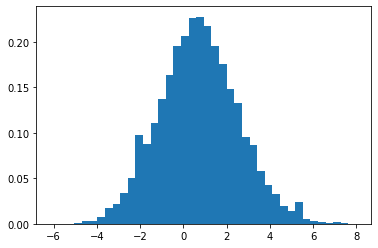

In [26]:
_ = plt.hist(baseline_model.coef_[0][n_players:], bins=40, density=True)

Тут кстати интересно, по-идее можно уточнить это распределение с учетом к примеру типа турнира или его численности. Тогда наверное можно использовать более точные распределения для оценки рейтинга, ясно что на сложном турнире будет преимущество у той команды, где есть хотя бы один очень сильный игрок, а на простом будет у той, где просто много средних игроков. Но до этого уже не дошли руки.

Для EM алгоритма я выбрал следующую схему. Мы знаем, что в команде точно кто то ответил на вопрос, если есть запись что команда ответила на вопрос. Но кто? Кто именно мы не можем узнать. Но давайте предположим, что мы знаем хотя бы количество тех кто знал ответ на вопрос. Это и будут наши скрытые переменные $z_n$. Но тогда, зная что из |T| игроков на вопрос ответили $z_n$ игроков из них, и зная априорные вероятности каждого из игроков ответить на этот вопрос (которые мы возьмем из предсказаний модели, ведь именно это она и оценивает), мы можем построить апосториорную вероятность того, что игрок ответил на вопрос:
$$P(player_i \quad answers \quad question_j | z_n) = P(p_i=1|q_j,z_n) =$$
$$$$
$$= \frac{P(z_n|p_i=1,q_j)P(p_i=1|q_j)}{P(z_n|p_i=1,q_j)P(p_i=1|q_j)+P(z_n|p_i=0,q_j)P(p_i=0|q_j)} = $$
$$$$
$$= \frac{P(z_n|p_i=1)\sigma(w_i - q_j)}{P(z_n|p_i=1)\sigma(w_i - q_j)+P(z_n|p_i=0)(1 - \sigma(w_i - q_j))}$$
$$$$
$$P(z_n|p_i=1) = PoissonBinomialDistributionPMF(p_1,p_2,...,p_{|T|}(exlude \quad p_i),k=z_n-1)$$
$$P(z_n|p_i=0) = PoissonBinomialDistributionPMF(p_1,p_2,...,p_{|T|}(exlude \quad p_i),k=z_n)$$

Итак, на E шаге оцениваем: $$z_n=E[T=1|q_j]=\sum_{i=0}^{|T|}E[p_i=1|q_j]=\sum_{i=0}^{|T|}P(p_i=1|q_j)=\sum_{i=0}^{|T|}\sigma(w_i - q_j)$$

На M шаге - пересчитываем $y_i=P(p_i=1|z_n)$ для тех случаев, когда команда ответила на вопрос, и используем полученные вероятности в качестве весов для переобучения логистической регрессии.

In [54]:
current_model = baseline_model

print("Baseline Model:")
models = [(baseline_model, 
           compute_model_scores(baseline_model, train_data, 'train'), 
           compute_model_scores(baseline_model, test_data, 'test'))]

player_prob_answer = current_model.predict_proba(X)[:,1]

for i in range(1, 6):
    print(f"EM iteration {i}:")
    pool = mp.Pool(36)
    y = np.sum(pool.map(partial(construct_scores, player_prob_answer=player_prob_answer, n=train_data.score.shape),
                        np.array_split(question_answered_index, 36)), axis=0)
    pool.close()                              
    weights = np.concatenate([y, 1 - y[train_data_good.row_id]])
    weights[train_data[train_data.score == 0].row_id] = 1
    
    current_model = LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=1000)
    current_model.fit(X_weighted, target, sample_weight=weights)
    
    player_prob_answer = current_model.predict_proba(X)[:,1]
    
    models.append((current_model, 
                   compute_model_scores(current_model, train_data, 'train'), 
                   compute_model_scores(current_model, test_data, 'test')))

Baseline Model:
train: spearmanr: 0.8226325775265949, kendalltau: 0.6573463450639639
test: spearmanr: 0.7013810964132426, kendalltau: 0.5406494769389477
EM iteration 1:
train: spearmanr: 0.828546744904034, kendalltau: 0.6639129054406849
test: spearmanr: 0.7055791124570412, kendalltau: 0.5443588345473775
EM iteration 2:
train: spearmanr: 0.8316790932082293, kendalltau: 0.6673905544172395
test: spearmanr: 0.7047837220386347, kendalltau: 0.5434115877746017
EM iteration 3:
train: spearmanr: 0.8333873993825741, kendalltau: 0.6692043052660832
test: spearmanr: 0.7044762737368778, kendalltau: 0.5436310821467004
EM iteration 4:
train: spearmanr: 0.8355050089444483, kendalltau: 0.6717088709693477
test: spearmanr: 0.7007887267149332, kendalltau: 0.5388304923735747
EM iteration 5:
train: spearmanr: 0.8370820551988446, kendalltau: 0.6733333080063378
test: spearmanr: 0.7012029941335657, kendalltau: 0.5389760773171687


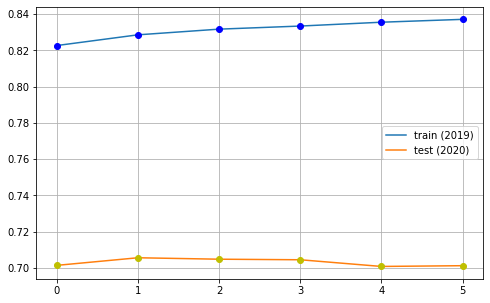

In [55]:
plt.figure(figsize=(8,5))
plt.plot([m[1][0] for m in models], label='train (2019)')
plt.plot([m[1][0] for m in models], 'bo')
plt.plot([m[2][0] for m in models], label='test (2020)')
plt.plot([m[2][0] for m in models], 'yo')
plt.grid(True)
plt.legend()

Итак мы видим, что EM алгоритм действительно сходится - с каждым шагом он улучшает метрики на train'е, т.е. он оптимизирует рейтинг систему на тех данных, на которых он обучается. Но к сожалению, на test'е происходит переобучение уже после первой итерации. Поэтому если мы хотим получить некоторый рейтинг по итогам 2019 года - то можно обучать модель и дальше и интерпретировать эти результаты соотвественно как успех игроков за прошедший год. Но вот если мы хотим предсказывать результаты новых турниров, то лучше взять первую модель. Хочется посмотреть на то, что в итоге наобучал EM алгоритм, поэтому возьму модель с последней итерации, тем более что на тесте метрики все равно еще не так сильно просели.

In [116]:
chosen_model = models[-1][0]

Теперь давайте построим рейтинг лист турниров по сложности вопросов, воспользуемся тем же трюком: возьмем эмпирическое распределение силы игроков, и проинтегрируем по этому распределению находя вероятность того, что вопрос останется без ответа, по каждому вопросу в турнире.

In [117]:
player_weights = chosen_model.coef_[0][:n_players]
player_weights_distrib = empirical_distribution(player_weights, 20)

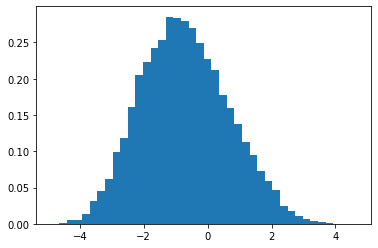

In [118]:
_ = plt.hist(player_weights, bins=40, density=True)

In [119]:
thdf = compute_tournaments_hardness(train_data, chosen_model, player_weights_distrib)

In [120]:
print("Top 10 самых сложных турниров:")
for t_id in thdf.tournament_id[:10]:
    print(t_id, tournaments[t_id]['name'])

Top 10 самых сложных турниров:
6149 Чемпионат Санкт-Петербурга. Первая лига
5928 Угрюмый Ёрш
5684 Синхрон высшей лиги Москвы
5947 Чемпионат Мира. Этап 3. Группа С
5946 Чемпионат Мира. Этап 3. Группа В
6101 Воображаемый музей
5741 All Cats Are Beautiful
5950 Чемпионат Мира. Финал. Группа С
5996 Тихий Донец: омут первый
5943 Чемпионат Мира. Этап 2 Группа С


In [121]:
print("Top 10 самых простых турниров:")
for t_id in thdf.tournament_id[-10:]:
    print(t_id, tournaments[t_id]['name'])

Top 10 самых простых турниров:
5488 Чемпионат Беларуси среди школьников
6008 Малый кубок Физтеха
5457 Студенческий чемпионат Калининградской области
6011 Щит и Меч
5660 Первая лига ЧТ
5405 Кавалькада волхвов
5706 (а)Синхрон-lite. Лига старта. Эпизод XI
5592 Студенческая лига ЧТ
6090 Дзержинский марафон
5827 Шестой киевский марафон. Асинхрон


Кажется все получилось логично, самые сложные турниры - это разные чемпионаты мира. А турнир Угрюмый Ерш вообще полностью называется Угрюмый Ёрш 2: Невыносимая сложность (https://rating.chgk.info/tournament/5928) что довольно забавно.

Далее я построю рейтинг игроков вместе с количество вопросов, на которые они ответили

In [122]:
xdf = pd.merge(train_data[['player_num', 'player_id']],
               pd.DataFrame({'player_num': range(n_players), 'player_rating': chosen_model.coef_[0][:n_players]}))
xdf = xdf.drop_duplicates()
players = pd.merge(train_data, xdf[['player_id', 'player_rating']].drop_duplicates(), how='left')
players['question_played'] = players.groupby(['player_id']).question_num.transform('nunique')

In [123]:
players = players[['player_id', 'player_rating', 'question_played']].drop_duplicates()

In [124]:
players_data = joblib.load('chgk/players.pkl')

In [125]:
print(f'player_id \t\t\t\t questions played \t  name')
for r in players.sort_values(['player_rating'], ascending=False)[['player_id', 'question_played']].iloc[:50].values:
    name, surname = players_data[r[0]]['name'], players_data[r[0]]['surname']
    print(f'https://rating.chgk.info/player/{r[0]}\t {r[1]} \t\t\t {name} {surname}')

player_id 				 questions played 	  name
https://rating.chgk.info/player/220618	 270 			 Елена Вергизаева
https://rating.chgk.info/player/62252	 652 			 Тимур Боков
https://rating.chgk.info/player/82688	 396 			 Игорь Калгин
https://rating.chgk.info/player/36910	 513 			 Иван Эйхгольц
https://rating.chgk.info/player/82696	 432 			 Денис Заднепровский
https://rating.chgk.info/player/27403	 3059 			 Максим Руссо
https://rating.chgk.info/player/12307	 791 			 Светлана Иванцова
https://rating.chgk.info/player/22474	 75 			 Илья Немец
https://rating.chgk.info/player/2998	 830 			 Алексей Белоглазов
https://rating.chgk.info/player/28362	 504 			 Михаил Сафронов
https://rating.chgk.info/player/24384	 2037 			 Евгений Пашковский
https://rating.chgk.info/player/202093	 252 			 Дмитрий Андреев
https://rating.chgk.info/player/30631	 252 			 Станислав Стребков
https://rating.chgk.info/player/24779	 1053 			 Орест Петросянц
https://rating.chgk.info/player/34846	 2096 			 Антон Чернин
https://rating.

В топе игроков идут в перемешку и крутые и действительно "ноунеймы". Например Елена Вергизаева сыграла какую то ласточку и стала самым крутым игроком. Семён Легашов играл в Кубке попкорна и стал топ-3 или Илья Немец заслужил славу на кубке Хэллоуна тп. Но например у Евгений Пашковский 2000 вопросов и он действительно кажется топовый игрок из известной команды, которая кстати вся в топе. Не говоря уже, что сам Сергей Николенко попал в непосредсвенный топ =)))) а значит моя рейтинг система не обманывает =))

In [131]:
def get_x__(df, additional_columns):
    """Констурируем спарсную матрицу для обучения - сначала идет OHE по игрокам потом OHE по вопросам 
    """
    
    N = df.shape[0]
    M = df.question_num.max() + 1
    
    data = np.concatenate([np.ones(N), -np.ones(N)])
    df_ = df.reset_index(drop=True).reset_index()
    i = np.concatenate([df_['index'].values, df_['index'].values])
    j = np.concatenate([df_['player_num'].values, df_['question_num'].values])
    
    for c in additional_columns:
        i = np.concatenate([i, df_['index'].values])
        j = np.concatenate([j, np.ones(df_.shape[0]) * M])
        data = np.concatenate([data, df_[c].values])
        M += 1
    
    return coo_matrix((data, (i, j)), shape=(N, M))

In [ ]:
PLAYER_COLUMNS = ['tournaments_played_last_1_month', 'tournaments_played_last_2_month', 'tournaments_played_last_3_month',
       'avg_position_last_1_month', 'avg_position_last_2_month', 'avg_position_last_3_month', 
       'avg_position_last_1_tournaments', 'avg_position_last_2_tournaments', 'avg_position_last_3_tournaments',
       'days_since_last_tournament', 'top_1_streak', 'top_3_streak']

QUESTION_COLUMNS = ['length', 'type', 'teams_count', 'rounds',
       'round', 'question_round_number', 'question_global_number']

In [ ]:
sample_with_player_data = compile_whole_sample(df)
train_data__ = pd.merge(train_data, sample_with_player_data[['tournament_id', 'player_id'] + PLAYER_COLUMNS], how='left', on=['tournament_id', 'player_id'])
X__ = get_x__(train_data__.fillna(0.0), PLAYER_COLUMNS)

In [113]:
m__ = LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=1000)
m__.fit(X__, train_data['score'])

In [ ]:
m__

Вообще у меня была идея смоделировать силу игрока фичами, которые имеют отношение к игроку, и сложность вопросов фичами, которые будут иметь отношение к турниру и самим вопросам. Тут я привел те фичи, которые я подобрал. К примеру, я читал в статьях, что очень хорошая фича для игрока будет 'winning streak' - сколько он уже подряд выиграл турниров. Вся эта информация может быть посчитана и на тесте, ведь ко дню проведения турнира нам уже известны все истинные результаты предыдущих турниров. 

Я думал сделать вместо $w_i$ и $q_j$ некие линейные функции $h(x)$ и $g(x)$, и обучить модель $P(p_i=1|q_j) = \sigma(h(x) - g(x))$

Но к сожалению, больше не успел сделать. Задание очень интересное, но достаточно сложное, конечно =) Спасибо